In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src/')

In [2]:
import sys
print(sys.path)

['C:\\Users\\Oliver\\Documents\\Academic\\Applied data analysis and machine learning\\Projects\\FYS-STK4155-project2\\notebooks', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\python39.zip', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\DLLs', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39', '', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\win32', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\win32\\lib', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\Pythonwin', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Oliver\\.ipython', '../src/']


In [3]:
from modelling.nn_backup import NeuralNetwork
nn = NeuralNetwork()

Input to neural network seems like it should be amount of features being polynomial features, at least according to this: https://medium.com/analytics-vidhya/polynomial-regression-with-keras-ef1797b39b88
As such I'll just create the same design matrix and feed it into the network.

In [4]:
from sklearn.model_selection import  train_test_split
from data.create_dataset import *
from sklearn.preprocessing import StandardScaler
X, z = create_dataset('../data/raw/SRTM_data_Norway_1.tif',degree=4)
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
Xscaler = StandardScaler().fit(X_train)
zscaler = StandardScaler().fit(z_train)

X_train = Xscaler.transform(X_train)
z_train = zscaler.transform(z_train)

In [ ]:
nn.initalize_layers(X_train.shape)

In [ ]:
i = 1
for layer in nn.layers:
    print(i)
    print(layer.weights.shape)
    print(layer.activations.shape)
    i+=1

In [ ]:
nn.fit(X_train,z_train,n_epochs = 1000)

In [6]:
from model_evaluation.metrics import *
MSE(z_train,nn.predict(X_train))

AttributeError: 'NoneType' object has no attribute 'weights'

In [7]:
from visualization.visualize import *
plot_surf_from_X(X_train,nn.predict(X_train),'NN prediction')

AttributeError: 'NoneType' object has no attribute 'weights'

In [ ]:
nn2 = NeuralNetwork(hidden_activation = 'relu')
nn2.fit(X_train,z_train,n_epochs = 10)
#plot_surf_from_X(X_train,nn2.predict(X_train),'NN prediction')

In [ ]:
nn2.n_samples

In [ ]:
plot_surf_from_X(X_train,nn2.predict(X_train),'NN prediction')

Now test with data set without feature matrix.

In [5]:
X, z = create_dataset('../data/raw/SRTM_data_Norway_1.tif')
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
Xscaler = StandardScaler().fit(X_train)
zscaler = StandardScaler().fit(z_train)

X_train = Xscaler.transform(X_train)
z_train = zscaler.transform(z_train)
z_train.shape

(8000, 1)

In [ ]:
plot_surf_from_X(X_train,z_train,'blabla')

### Own NN

In [8]:
nn3 = NeuralNetwork(hidden_activation = 'relu')
nn3.fit(X_train,z_train,n_epochs = 1000)

../src\visualization\visualize.py:42: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'NN prediction'}, xlabel='X', ylabel='Y'>

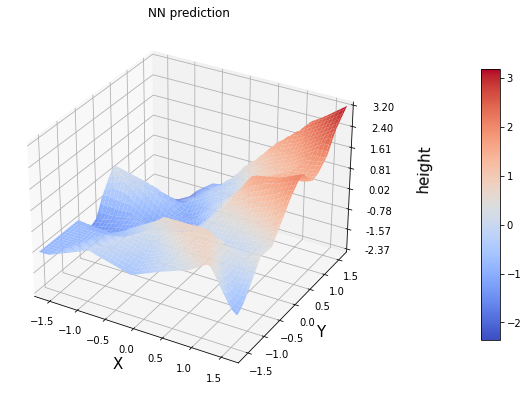

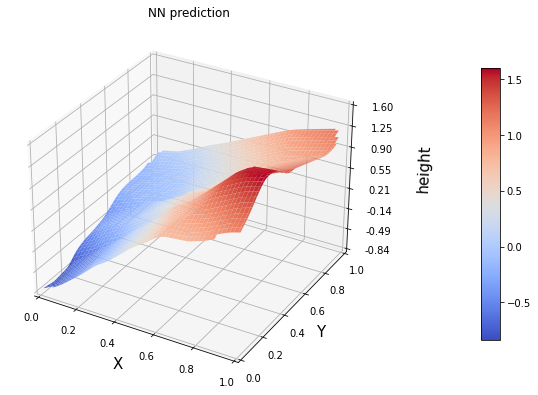

In [9]:
plot_surf_from_X(X_train,nn3.predict(X_train),'NN prediction')
plot_surf_from_X(X_test,nn3.predict(X_test),'NN prediction')

### Keras NN

In [10]:
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
initializer = tf.keras.initializers.GlorotUniform()
init_b = tf.keras.initializers.Constant(value=0.01)

model = keras.Sequential()

model.add(layers.Dense(50, kernel_initializer=initializer,bias_initializer= init_b, input_shape=(2,)))
model.add(layers.Activation('relu'))

model.add(layers.Dense(1, kernel_initializer=initializer,bias_initializer= init_b, input_shape=(50,)))
model.add(layers.Activation('linear'))

opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0)
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
model.fit(x=X_train,y=z_train, batch_size = 32, epochs=1000,verbose=0)

In [ ]:
plot_surf_from_X(X_train,model.predict(X_train),'Keras prediction')
plot_surf_from_X(X_test,model.predict(X_test),'Keras prediction')

### SKlearn NN

In [ ]:
from sklearn.neural_network import MLPRegressor

nn_sk = MLPRegressor(max_iter = 10000, hidden_layer_sizes=(50),
                     activation = 'relu',solver='sgd',
                     learning_rate_init=0.01,batch_size = 32,momentum= 0.0,alpha=0.0,tol=0)
nn_sk.fit(X_train,z_train.ravel())

In [ ]:
plot_surf_from_X(X_train,nn_sk.predict(X_train),'SK prediction')
plot_surf_from_X(X_test,nn_sk.predict(X_test),'SK prediction')

After much trial and error when using relu, I finally got it right. It seems like there was several mistakes, both with the momentum implementation and when calculating the bias gradient. The bias gradient in the lectures are calculated using a sum. SKlearn and Tensorflow uses the average which of course makes much more sense. Why would you sum all errors into one intercept? And not use the mean like we would with regression?

Last thing to test is expanding the layers

In [17]:
from modelling.nn import NeuralNetwork
nn4 = NeuralNetwork(hidden_layer_sizes=(50,50),w_init = 'uniform',hidden_activation = 'relu')
nn4.initialize(X_train.shape)
#nn4.fit(X_train,z_train,n_epochs = 1)

In [18]:
nn4.fit(X_train,z_train,n_epochs = 1000)

../src\modelling\nn.py:215: RuntimeWarning: overflow encountered in matmul
  error = (error @ weights.T)*self.layers[i].derivative(self.layers[i].z_h,error)
../src\modelling\nn.py:253: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)


KeyboardInterrupt: 

../src\visualization\visualize.py:42: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'NN prediction'}, xlabel='X', ylabel='Y'>

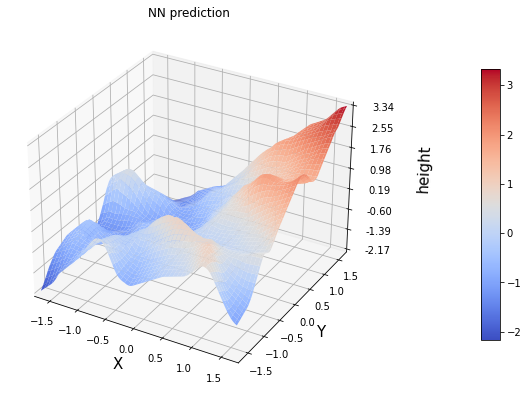

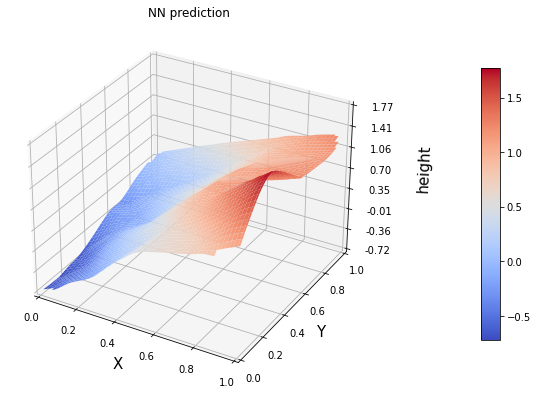

In [16]:
plot_surf_from_X(X_train,nn4.predict(X_train),'NN prediction')
plot_surf_from_X(X_test,nn4.predict(X_test),'NN prediction')

In [ ]:
from sklearn.neural_network import MLPRegressor

nn_sk2 = MLPRegressor(max_iter = 10000, hidden_layer_sizes=(50,50),
                     activation = 'relu',solver='sgd',
                     learning_rate_init=0.01,batch_size = 32,momentum= 0.0,alpha=0.0,tol=0)
nn_sk2.fit(X_train,z_train.ravel())

In [ ]:
plot_surf_from_X(X_train,nn_sk2.predict(X_train),'SK prediction')
plot_surf_from_X(X_test,nn_sk2.predict(X_test),'SK prediction')

In [19]:
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
#initializer = tf.keras.initializers.GlorotUniform()
init_b = tf.keras.initializers.Constant(value=0.01)

model = keras.Sequential()

model.add(layers.Dense(50, kernel_initializer=initializer,bias_initializer= init_b, input_shape=(2,)))
model.add(layers.Activation('relu'))

model.add(layers.Dense(50, kernel_initializer=initializer,bias_initializer= init_b, input_shape=(50,)))
model.add(layers.Activation('relu'))

model.add(layers.Dense(1, kernel_initializer=initializer,bias_initializer= init_b, input_shape=(50,)))
model.add(layers.Activation('linear'))

opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0)
model.compile(loss='mean_squared_error', optimizer=opt)
model.fit(x=X_train,y=z_train, batch_size = 32, epochs=1000,verbose=0)

../src\visualization\visualize.py:43: RuntimeWarning: All-NaN slice encountered
  linewidth=0, antialiased=True,vmin=np.nanmin(z), vmax=np.nanmax(z))


ValueError: Axis limits cannot be NaN or Inf

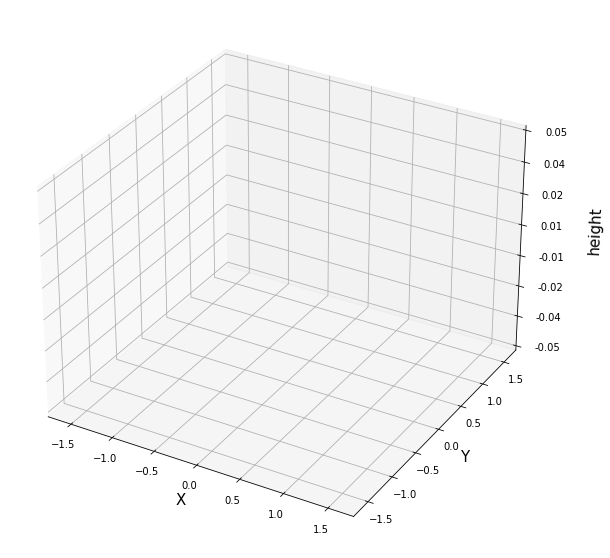

In [20]:
plot_surf_from_X(X_train,model.predict(X_train),'Keras prediction')
plot_surf_from_X(X_test,model.predict(X_test),'Keras prediction')

Amazing! It turns out the initialization of the weights is very important to avoid exploding gradients. Using the initialization suggested by glorot really did the trick.